# TP 3 - NLP - Embeddings


<img src="https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/logoFIUBA.jpg" width="500" align="center">


### Alumno: Domenje Carlos R.

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).
- Graficarlos.
- Obtener conclusiones.


### Librerias a utilizar

In [22]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.text import text_to_word_sequence 
from keras.preprocessing.sequence import pad_sequences 
from keras.layers import Bidirectional    

In [2]:
# Lectura del dataset
path_base = "./data/"
file_name = os.listdir(path_base)
file_name

['moby-dick.txt']

#### Lectura del libro

In [3]:
file = open(path_base+file_name[0], mode="rt", encoding='utf-8')
text=file.read()
file.close()

text

'The Project Gutenberg eBook of Moby-Dick; or The Whale, by Herman Melville\n\nThis eBook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this eBook or online at\nwww.gutenberg.org. If you are not located in the United States, you\nwill have to check the laws of the country where you are located before\nusing this eBook.\n\nTitle: Moby-Dick; or The Whale\n\nAuthor: Herman Melville\n\nRelease Date: June, 2001 [eBook #2701]\n[Most recently updated: August 18, 2021]\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\nProduced by: Daniel Lazarus, Jonesey, and David Widger\n\n*** START OF THE PROJECT GUTENBERG EBOOK MOBY-DICK; OR THE WHALE ***\n\n\n\n\nMOBY-DICK;\n\nor, THE WHALE.\n\nBy Herman Melville\n\n\n\nCONTENTS\n\nETYMOLOGY.\n\nEXTRACTS (Supplied by a Sub-Sub-Librarian).\n\nCHA

#### Separación de texto por párrafos - Eliminación de vacios.

In [4]:
txt_list = text.split("\n")
txt_list = list(filter(None, txt_list))
txt_list

['The Project Gutenberg eBook of Moby-Dick; or The Whale, by Herman Melville',
 'This eBook is for the use of anyone anywhere in the United States and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. You may copy it, give it away or re-use it under the terms',
 'of the Project Gutenberg License included with this eBook or online at',
 'www.gutenberg.org. If you are not located in the United States, you',
 'will have to check the laws of the country where you are located before',
 'using this eBook.',
 'Title: Moby-Dick; or The Whale',
 'Author: Herman Melville',
 'Release Date: June, 2001 [eBook #2701]',
 '[Most recently updated: August 18, 2021]',
 'Language: English',
 'Character set encoding: UTF-8',
 'Produced by: Daniel Lazarus, Jonesey, and David Widger',
 '*** START OF THE PROJECT GUTENBERG EBOOK MOBY-DICK; OR THE WHALE ***',
 'MOBY-DICK;',
 'or, THE WHALE.',
 'By Herman Melville',
 'CONTENTS',
 'ETYMOLOGY.',
 'EXTRACTS (Supplied by a 

In [5]:
# Armar el dataset
df  = pd.DataFrame(txt_list)
df.head()

,0
0,The Project Gutenberg eBook of Moby-Dick; or T...
1,This eBook is for the use of anyone anywhere i...
2,most other parts of the world at no cost and w...
3,"whatsoever. You may copy it, give it away or r..."
4,of the Project Gutenberg License included with...


In [6]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 19229


### Preprocesamiento

In [7]:
# largo de la secuencia, incluye seq input + word output
train_len = 4
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
#Quito los espacios repetidos, que hay muchos en el texto
corpus = re.sub(r'\s+', ' ', corpus)
corpus

'The Project Gutenberg eBook of Moby-Dick; or The Whale, by Herman Melville This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. Title: Moby-Dick; or The Whale Author: Herman Melville Release Date: June, 2001 [eBook #2701] [Most recently updated: August 18, 2021] Language: English Character set encoding: UTF-8 Produced by: Daniel Lazarus, Jonesey, and David Widger *** START OF THE PROJECT GUTENBERG EBOOK MOBY-DICK; OR THE WHALE *** MOBY-DICK; or, THE WHALE. By Herman Melville CONTENTS ETYMOLOGY. EXTRACTS (Supplied by a Sub-Sub-Librarian). CHAPTER 1. Loomings. CHAPTER 2. The Carpet-Bag. CHAPTER 3. The Sp

#### Corpus a Tokens

In [8]:
# Vemos los tokens de algunas oraciones
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
print("Cantidad de tokens en el corpus:", len(tokens))
print("Primeros tokens del corpus: ")
tokens[:10]

Cantidad de tokens en el corpus: 220771
Primeros tokens del corpus: 


['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'moby',
 'dick',
 'or',
 'the',
 'whale']

#### Transformacion de tokens en secuencias de palabras

In [9]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [10]:
print("Primeros vectores  de texto generados: \n")
text_sequences[:10]

Primeros vectores  de texto generados: 



[['the', 'project', 'gutenberg', 'ebook'],
 ['project', 'gutenberg', 'ebook', 'of'],
 ['gutenberg', 'ebook', 'of', 'moby'],
 ['ebook', 'of', 'moby', 'dick'],
 ['of', 'moby', 'dick', 'or'],
 ['moby', 'dick', 'or', 'the'],
 ['dick', 'or', 'the', 'whale'],
 ['or', 'the', 'whale', 'by'],
 ['the', 'whale', 'by', 'herman'],
 ['whale', 'by', 'herman', 'melville']]

#### Secuencia de texto a números

In [11]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [12]:
print("Primeros vectores de numeros generados: \n")
sequences[:10]

Primeros vectores de numeros generados: 



[[1, 249, 234, 1601],
 [249, 234, 1601, 2],
 [234, 1601, 2, 286],
 [1601, 2, 286, 287],
 [2, 286, 287, 32],
 [286, 287, 32, 1],
 [287, 32, 1, 25],
 [32, 1, 25, 22],
 [1, 25, 22, 5353],
 [25, 22, 5353, 5354]]

In [13]:
print("Cantidad de secuencias generadas:", len(sequences))

Cantidad de secuencias generadas: 220767


In [14]:
# Vemos el index_word del tokenizador, que esta ordenado por las palabras más populares a menos populares
tok.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'a',
 5: 'to',
 6: 'in',
 7: 'that',
 8: 'his',
 9: 'it',
 10: 'i',
 11: 'with',
 12: 'but',
 13: 'he',
 14: 'as',
 15: 'is',
 16: 'was',
 17: 'for',
 18: 'all',
 19: 'this',
 20: '”',
 21: 'at',
 22: 'by',
 23: 'not',
 24: 'from',
 25: 'whale',
 26: 'be',
 27: 'on',
 28: 'him',
 29: 'so',
 30: 'you',
 31: 'one',
 32: 'or',
 33: 'had',
 34: 'have',
 35: 'now',
 36: 'there',
 37: 'were',
 38: 'they',
 39: 'which',
 40: 'like',
 41: 'their',
 42: 'me',
 43: 'are',
 44: 'then',
 45: 'some',
 46: 'when',
 47: 'an',
 48: 'my',
 49: 'upon',
 50: 'no',
 51: 'out',
 52: 'into',
 53: 'up',
 54: 'more',
 55: 'what',
 56: 'if',
 57: 'them',
 58: 'man',
 59: 'sea',
 60: 'old',
 61: 'we',
 62: 'ship',
 63: 'would',
 64: 'ahab',
 65: 'ye',
 66: 'other',
 67: 'been',
 68: 'over',
 69: 'these',
 70: 'will',
 71: 'its',
 72: 'such',
 73: 'down',
 74: 'only',
 75: 'any',
 76: 'though',
 77: 'yet',
 78: 'head',
 79: 'long',
 80: 'who',
 81: 'time',
 82: 'her',
 83: 've

#### Generacion de vectores de input y target

In [15]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] 

print("Shape del vector x_data:" ,x_data.shape)
print("Shape del vector y_data_int:" ,y_data_int.shape)

Shape del vector x_data: (220767, 3)
Shape del vector y_data_int: (220767,)


#### OHE de vector y_data

In [16]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

19590

In [17]:
# Transformar los datos a oneHotEncoding
y_data_int_offset = y_data_int - 1 # Restamos 1 en el y_data_int para que comience en 0 y no en 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
print("Shape de y_data: ",y_data.shape)

Shape de y_data:  (220767, 19590)


#### Entrenamiento del modelo - 2 arquitecturas de red

In [18]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [19]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size


19590

#### Modelo 1

In [20]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 5)              97955     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 64)             17920     
_________________________________________________________________
dropout (Dropout)            (None, 3, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 19590)             646470    
Total params: 797,449
Trainable params: 797,449
Non-trainable params: 0
__________________________________________________

#### Entrenamiento del modelo 

In [21]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.3)

2022-11-28 10:09:58.777891: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-28 10:09:58.778136: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
4830/4830 [==============================] - 40s 8ms/step - loss: 7.2018 - accuracy: 0.0656 - val_loss: 7.2354 - val_accuracy: 0.0664
Epoch 2/50
4830/4830 [==============================] - 39s 8ms/step - loss: 6.7600 - accuracy: 0.0812 - val_loss: 7.2631 - val_accuracy: 0.0796
Epoch 3/50
4830/4830 [==============================] - 38s 8ms/step - loss: 6.5066 - accuracy: 0.0894 - val_loss: 7.2755 - val_accuracy: 0.0834
Epoch 4/50
4830/4830 [==============================] - 39s 8ms/step - loss: 6.3324 - accuracy: 0.0960 - val_loss: 7.3194 - val_accuracy: 0.0863
Epoch 5/50
4830/4830 [==============================] - 38s 8ms/step - loss: 6.1919 - accuracy: 0.1007 - val_loss: 7.4077 - val_accuracy: 0.0896
Epoch 6/50
4830/4830 [==============================] - 38s 8ms/step - loss: 6.0758 - accuracy: 0.1043 - val_loss: 7.5461 - val_accuracy: 0.0907
Epoch 7/50
4830/4830 [==============================] - 38s 8ms/step - loss: 5.9713 - accuracy: 0.1074 - val_loss: 7.5578 - val_ac

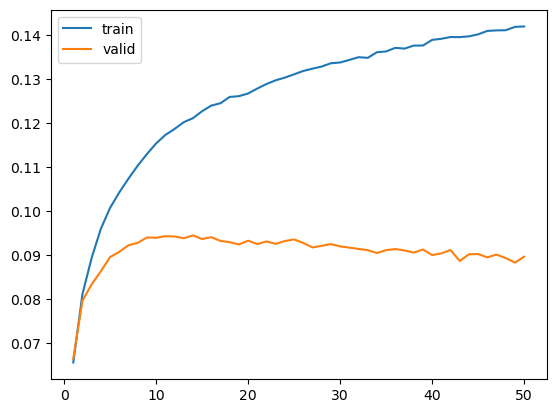

In [23]:
# Graficamos accuracy en train y validacion
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

#### Modelo 2 

In [24]:
model2 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 6283 palabras distintas
output_dim = 10 #--> tamaño del embeding a generar
model2.add(Embedding(input_dim=vocab_size+1, output_dim=output_dim, input_length=input_seq_len))

model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Dropout(0.15))
model2.add(Bidirectional(LSTM(128)))
model2.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 6283 palabras posibles
model2.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 10)             195910    
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 128)            38400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 19590)             646470    
Total params: 1,152,172
Trainable params: 1,152,172
Non-trainable params: 0
____________________________________________

In [25]:
hist2 = model2.fit(x_data, y_data, epochs=50, validation_split=0.3)

Epoch 1/50
4830/4830 [==============================] - 55s 11ms/step - loss: 7.0754 - accuracy: 0.0719 - val_loss: 7.1473 - val_accuracy: 0.0782
Epoch 2/50
4830/4830 [==============================] - 52s 11ms/step - loss: 6.6044 - accuracy: 0.0907 - val_loss: 7.1469 - val_accuracy: 0.0866
Epoch 3/50
4830/4830 [==============================] - 53s 11ms/step - loss: 6.3379 - accuracy: 0.1039 - val_loss: 7.2755 - val_accuracy: 0.0913
Epoch 4/50
4830/4830 [==============================] - 51s 11ms/step - loss: 6.1338 - accuracy: 0.1108 - val_loss: 7.3570 - val_accuracy: 0.0948
Epoch 5/50
4830/4830 [==============================] - 53s 11ms/step - loss: 5.9659 - accuracy: 0.1168 - val_loss: 7.4529 - val_accuracy: 0.0948
Epoch 6/50
4830/4830 [==============================] - 51s 11ms/step - loss: 5.8239 - accuracy: 0.1212 - val_loss: 7.5578 - val_accuracy: 0.0958
Epoch 7/50
4830/4830 [==============================] - 52s 11ms/step - loss: 5.6980 - accuracy: 0.1273 - val_loss: 7.7530 -

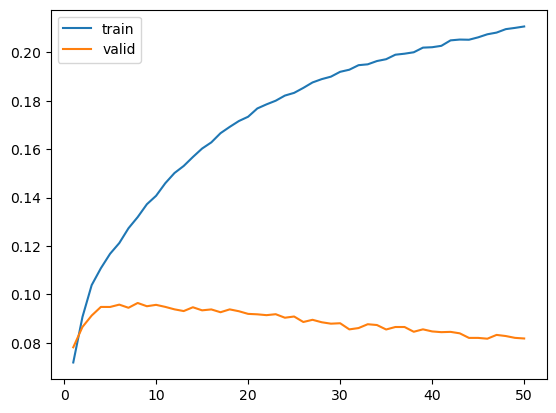

In [26]:
# Graficamos accuracy en train y validacion
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

#### Predicciones

In [28]:
def next_word(texto,modelo):

    # Encodeamos
    encoded = tok.texts_to_sequences([texto])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = modelo.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por el modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return texto + ' ' + out_word

In [35]:
text_test = "while both elastic"
prediccion_modelo1 = next_word(text_test,model)
print("Prediccion modelo 1: ",prediccion_modelo1)

Prediccion modelo 1:  while both elastic of


In [36]:
text_test = "while both elastic"
prediccion_modelo2 = next_word(text_test,model2)
print("Prediccion modelo 2: ",prediccion_modelo2)

Prediccion modelo 2:  while both elastic of


#### GRADIO 

Se utiliza gradio para hacer varias pruebas a traves de la UI 

In [39]:
import sys
!{sys.executable} -m pip install gradio --quiet

In [40]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/opt/miniconda3/envs/nlp-env/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


#### Generacion de nuevas secuencias

In [41]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [42]:
input_text='while both elastic'
max_length = 3
n_words = 2

seq_modelo1 = generate_seq(model, tok, input_text, max_length=max_length, n_words=n_words)
print("Secuencia con el modelo 1: ",seq_modelo1)

Secuencia con el modelo 1:  while both elastic of 


In [43]:
input_text='while both elastic'
max_length = 3
n_words = 2

seq_modelo2 = generate_seq(model2, tok, input_text, max_length=max_length, n_words=n_words)
print("Secuencia con el modelo 2: ",seq_modelo2)


Secuencia con el modelo 2:  while both elastic of 


In [44]:
def prueba_modelo(input_text):
  seq_modelo = generate_seq(model2, tok, input_text, max_length=max_length, n_words=n_words)
  print("Prueba de secuencia: ",seq_modelo)

In [56]:
prueba_modelo('like an enormous')
prueba_modelo('The acute policy')
prueba_modelo('leaving such a')
prueba_modelo('Hast seen the')

Prueba de secuencia:  like an enormous island among
Prueba de secuencia:  The acute policy the horizontal
Prueba de secuencia:  leaving such a may strange
Prueba de secuencia:  Hast seen the from street


### Conclusion

Se realizaron dos modelos con diferentes configuraciones a fin de realizar varios tests en la prediccion. Por un lado tenemos solo capas LSTM y por otro lado en el modelo 2 tenemos LSTM con capa bidireccional.

El dataset utilizado es el libro de Moby Dick y consta de 220767 tokens y 19590 palabras.

Se realizo el entrenamiento con 50 epochs tomando como ejemplo lo visto en clases. Se probo cambiar el valor al doble pero el tiempo de entrenamiento es muy alto por lo que se decidio dejarlo en este valor para realizar pruebas del algoritmo.

Los resultados obtenidos no fueron positivos ya que las predicciones realizas no tienen sentido en las oraciones. Se podria mejorar el preprocesamiento del texto a fin de verificar si se logran mejores resultados que los obtenidos.
